<a href="https://colab.research.google.com/github/hyemworks/make-your-firstGAN-with-pytorch/blob/main/ch07_handwritten_number_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 07 &nbsp;&nbsp;&nbsp;&nbsp;Handwritten Number Training**


🦋 GAN 훈련법 (chapter 06 summary)

     (1) 실제 데이터셋 미리 살펴보기
     (2) 판별기가 적어도 임의의 노이즈와 실제 데이터를 구별하도록 학습할 수 있을 성능은 지니는지 확인하기
     (3) 훈련되지 않은 생성기가 올바른 형태의 데이터를 만들어내는지 확인하기
     (4) 손실이 어떻게 변하는지 시각화하기


      + 생성기가 만들어낸 이미지 살펴보기

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

## 데이터셋 클래스


In [6]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
# MNIST DATASET CLASS

class MnistDataset(Dataset):

  # Constructor
  def __init__(self, csv_file):
    # csv_file 읽어오기
    self.data_df = pandas.read_csv(csv_file, header=None)


  def __len__(self):
    # 데이터 프레임의 길이 반환
    return len(self.data_df)


  # 특정 아이템을 인덱스를 통해 접근가능한 함수
  def __getitem__(self,index):
    
    label = self.data_df.iloc[index,0]                                          # 01. index번째 행의 첫번째 인덱스, 즉 정답레이블을 읽어옴.(정답은 0~9까지 존재)
    target = torch.zeros((10))                                                  # 02. target이란 변수명의 "정답" 종이 만들기
    target[label] = 1.0                                                         # 03. 정답 레이블의 위치에만 1로 지정. 나머지는 0 (원-핫 인코딩 방식)
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0  # 04. 데이터를 tensor로 묶은 후 정규화 (0 - 255의 이미지를 0 - 1로 정규화)

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target



  # MNIST 데이터셋 내의 특정 이미지를 골라 차트를 그려보는 메서드
  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28) # 2D(28*28)로 변형
    plt.title("label = " + str(self.data_df.iloc[index,0])) # 정답레이블 제목으로 붙이기
    plt.imshow(img, interpolation='none', cmap = 'Blues')   # 나타내기

훈련 셋의 임의의 이미지를 불러와 그려보면서 데이터셋 클래스가 제대로 작동하는지 확인해보자

In [ ]:
# Load MNIST Train Data

mnist_dataset = MnistDataset("mount/My Drive/Colab Notebooks/make-your-firstGAN-with-pytorch/mnist_data/mnist_train.csv")

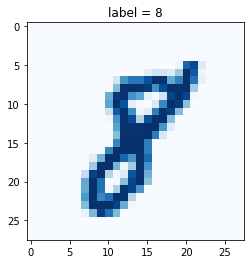

In [ ]:
# Check data contains images

mnist_dataset.plot_image(17)

## MNIST 판별기

In [ ]:
class Discriminator(nn.Module):
  
  # Constructor
  def __init__(self):

    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의 - 통과시킬 레이어를 순서대로 기술
    self.model = nn.Sequential(
        nn.Linear(784, 200),    # Linear : 완전연결 매핑을 의미 => 여기에서는 훈련 시 노드를 업데이트할 가중치에 대한 정보도 포함되어 있음
        nn.Sigmoid(),
        nn.Linear(200, 1),      # Linear : ,,
        nn.Sigmoid()
    )

    # Loss Function 설정
    self.loss_function = nn.MSELoss()

    # Optimizer 설정
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 훈련 시각화 (train 함수에서 사용될 변수 초기화)
    self.counter = 0
    self.progress = []


  # forward function : 네트워크에 정보 전달
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)


  # train
  def train(self, inputs, targets):
    # inputs  : 신경망에 전달할 입력  
    # targets : 원하는 목표 --> 이를 통해 손실을 계산

    ### 신경망 출력 계산
    outputs = self.forward(inputs)  # train 함수에서 가장 먼저 해야할 일! == forward()로 입력값을 신경망에 전달하여 결과를 얻어내는 것
    
    ### 손실 계산
    loss = self.loss_function(outputs, targets)
    #  계산 그래프의 마지막 노드는 손실함수!
    #   => 손실 계산을 위해 각 노드에서 기울기가 변하는 것은 각 학습 파라미터가 변할 때마다 손실이 변하는 것과 같음
    

    ### 훈련 시각화 (모니터링)
    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item()) # item() : 텐서에서 값을 꺼내오는 함수
    if (self.counter % 10000 == 0):
        print("counter = ", self.counter)


    ### 손실을 사용해 네트워크의 가중치를 업데이트
    # 기울기 초기화
    self.optimizer.zero_grad()  # 계산 그래프의 기울기가 모두 0으로 초기화
                                #   : 신경망을 훈련할 때마다 매번 기울기는 0으로 설정되어 있어야 함
                                #      => 그렇게 하지 않으면 loss.backward()를 따라 계산마다 쌓이게 됨
    # 역전파 실행
    loss.backward()
    # 가중치 갱신
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
  

## 판별기 테스트하기

생성기를 만들기 전에, 판별기가 실제 이미지와 임의의 노이즈 간에 구별을 할 수 있는지 한번 확인해보자!

In [ ]:
def generate_random(size):
  random_data = torch.rand(size)  # 0과 1사이의 size개의 값을 가진 텐서를 반환
  return random_data

In [ ]:
%%time

# 60,000개의 이미지를 훑으면서 판별기가 진짜 숫자라고 판단하면 결과를 1.0으로 출력하도록 하는 코드

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  # real data
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  # fake data
  D.train(generate_random(784), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 1min 59s, sys: 1.24 s, total: 2min
Wall time: 2min


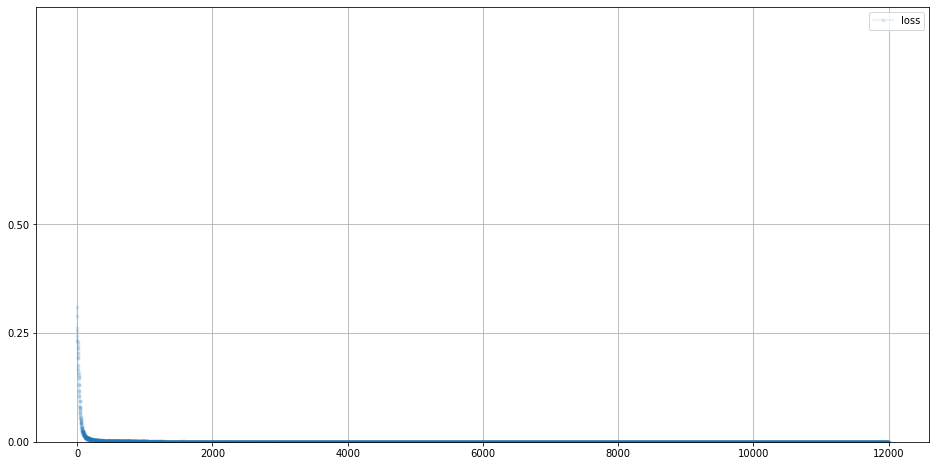

In [ ]:
# plot discriminator loss

D.plot_progress()

이제 훈련된 판별기에 임의로 선택한 이미지를 수동으로 넣어 결과를 한번 확인해보자.

In [ ]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item())

for i in range(4):
  print( D.forward( generate_random(784) ).item())
  

0.9967471361160278
0.9936259984970093
0.9967108964920044
0.9980775117874146
0.005591799505054951
0.004646739456802607
0.005566582083702087
0.00659315288066864


<br>

---

<br>

#### 🔥 **헷갈리는 부분 짚고 넘어가자!**

위 코드에서, <code>image_data_tensor = mnist_dataset[random.randint(0,60000)][1]</code> 부분이<br>
random하게 60000개의 훈련 데이터 중 하나를 고르는 것은 알겠는데,,, **[1]의 정체는 뭔지 직관적으로 확실히는 모르겠다**
```
# 특정 아이템을 인덱스를 통해 접근가능한 함수
  def __getitem__(self,index):
    
    label = self.data_df.iloc[index,0]                                          
    target = torch.zeros((10))                                                  
    target[label] = 1.0                                                         
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0  

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target
```



In [ ]:
print(mnist_dataset[random.randint(0,60000)])
print("\n\n")
print(mnist_dataset[random.randint(0,60000)][0])
print(mnist_dataset[random.randint(0,60000)][1])
print(mnist_dataset[random.randint(0,60000)][2])
print(mnist_dataset[random.randint(0,60000)][3])

(4, tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.00

IndexError: ignored

> 🔥 직접 출력한 결과로 미루어볼때,<br>
<br>
MnistDataset 클래스의 객체를 통해 **특정 아이템을 인덱스를 통해 접근가능한 함수**를 활용하면<br>
해당 함수의 반환값은 <code>return label, image_values, target</code>로,<br>
즉, **(label, image_values, target)**의 **tuple** 형태로 나옴을 확인할 수 있다!<br>
<br>
➡ 따라서 해당 tuple에서 원하는 값인 <code>image_data_tensor</code>를 뽑아내기 위해 **인덱스 번호 1**을 할당한 것이다!

<br>

---

<br>

## MNIST 생성기

#### 🔥 신경망은 훈련과정 자체에 어느정도 임의적인 요소는 있을 수 있으나, **같은 입력값에 대해서는 항상 같은 출력을 낸다는 점은 변하지 않는다!**

<br>

➡ &nbsp;&nbsp;따라서, MNIST 생성기의 입력은 매 훈련 사이클마다 **임의적인 값**을 사용해야한다!<br>
&nbsp;&nbsp;&nbsp;&nbsp; 우리 코드를 **임의의 시드$^{random-seed}$**에서 숫자를 생성하도록 바꿔보자

In [ ]:
class Generator(nn.Module):


  def __init__(self):
    
    # 파이토치 부모클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1,200),
        nn.Sigmoid(),
        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # 옵티마이저 설정
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행측정을 위한 변수 초기화
    self.counter = 0
    self.progress = []
    self.image_list = []



  def forward(self, inputs):
    
    # 모델 실행
    return self.model(inputs)



  def train(self, D, inputs, targets):

    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차계산
    loss = D.loss_function(d_output, targets)


    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter %10 == 0):
      self.progress.append(loss.item())
    
    # 매 1000회마다 이미지 저장
    if (self.counter % 1000 == 0):
      self.image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy())


    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))



## 생성기 결과 테스트하기

훈련되지 않은 생성기가 올바른 형태의 데이터를 만들어내는지 확인하자

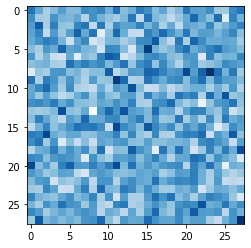

In [ ]:
# Check the generator output is of the right type and shape

G = Generator()

output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
# 궁금해서 프린트

G = Generator()

output = G.forward(generate_random(1))

print(output)                                       # tensor([f, f, f, ... , f, f], grad_fn=<SigmoidBackward0>))
print(output.shape)                                 # torch.Size([784])
print("--------------------------------------------------")
print(output.detach())                              # tensor([f, f, f, ... , f, f])
print(output.detach().shape)                        # torch.Size([784])
print("--------------------------------------------------")
print(output.detach().numpy())                      # [f, f, f, ... , f, f]
print(output.detach().numpy().shape)                # (784,)
print("--------------------------------------------------")
print(output.detach().numpy().reshape(28,28))       # [[f,f,...,f], [f,f, ...,f], ... ,[f,f,...,f]]
print(output.detach().numpy().reshape(28,28).shape) # (28, 28)


tensor([0.4742, 0.5361, 0.5470, 0.4350, 0.4435, 0.5961, 0.5139, 0.5295, 0.4864,
        0.4999, 0.4203, 0.4354, 0.5071, 0.5993, 0.3997, 0.5849, 0.6362, 0.4794,
        0.5005, 0.6815, 0.5990, 0.5706, 0.5719, 0.5379, 0.5429, 0.5861, 0.6446,
        0.4332, 0.3977, 0.4928, 0.5631, 0.4476, 0.5222, 0.5462, 0.5637, 0.5590,
        0.5390, 0.5107, 0.5461, 0.4571, 0.4473, 0.4753, 0.4846, 0.5256, 0.5968,
        0.4707, 0.5361, 0.5103, 0.4512, 0.3698, 0.5379, 0.4010, 0.5232, 0.4193,
        0.3640, 0.5377, 0.5731, 0.5546, 0.6416, 0.6369, 0.4629, 0.4904, 0.4227,
        0.4669, 0.3989, 0.4862, 0.5837, 0.5080, 0.5099, 0.5587, 0.6078, 0.7138,
        0.5012, 0.4039, 0.4434, 0.4506, 0.5595, 0.6717, 0.4372, 0.4659, 0.4890,
        0.5850, 0.5178, 0.5470, 0.3840, 0.4933, 0.4877, 0.4592, 0.3635, 0.4673,
        0.4592, 0.5092, 0.3831, 0.7209, 0.5289, 0.5955, 0.5002, 0.5675, 0.6152,
        0.4928, 0.5975, 0.5056, 0.5753, 0.5002, 0.4627, 0.6139, 0.5146, 0.5637,
        0.3861, 0.5155, 0.5213, 0.5337, 

#### 🔥 순전파의 결과
> * **Discriminator** &nbsp;==> &nbsp;**torch.Size( [ 1 ] )** &nbsp;&nbsp;&nbsp;&nbsp;: ( 1 , )
* **Generator** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;==> &nbsp;**torch.Size( [ 784 ] )** : ( 784 , )

## GAN 훈련하기

In [ ]:
%%time

# Create Discriminator and Generator

D = Discriminator()
G = Generator()


# Train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:
  
  # 01. train dicriminator on "real data"
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 02. train discriminator on "fake data"
  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
          # use detach() so gradients in G are not calculated

  # 03. train generator
  G.train(D, generate_random(1), torch.FloatTensor([1.0]))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 21s, sys: 2.49 s, total: 3min 24s
Wall time: 3min 23s


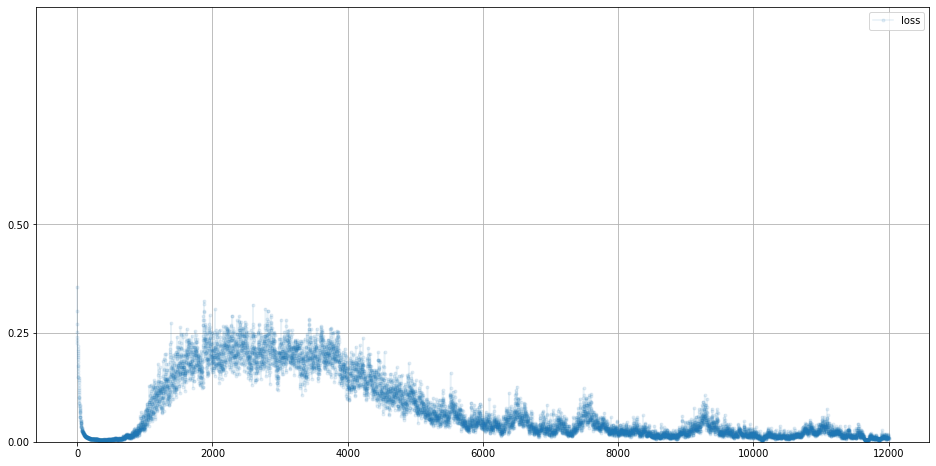

In [ ]:
# plot discriminator error

D.plot_progress()

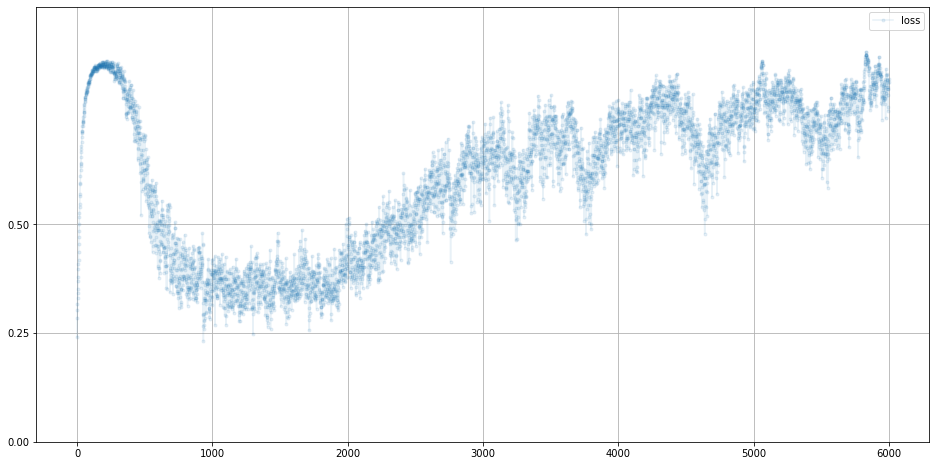

In [ ]:
# plot generator error

G.plot_progress()

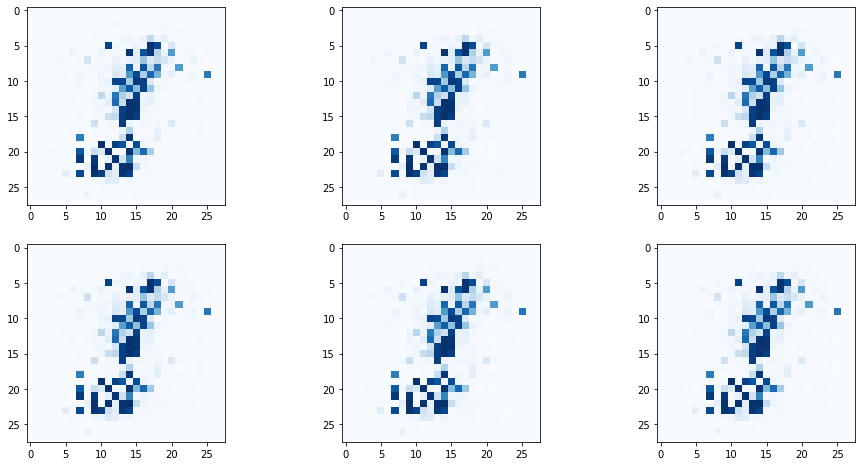

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')


## 모드 붕괴

##### ✅ **모드붕괴, mode collapse**
* GAN을 훈련할 때 자주 맞닥뜨리는 현상
* MNIST 예제에서 생성기가 10개의 숫자를 다양하게 생성해내는 것이 바람직하나, **오직 하나만 만들게 되거나, 선택지의 극히 일부만 만들게 되는 경우**
* 위의 경우가 모드붕괴가 발생한 사례임

<br>

##### 🦋 **모드붕괴가 왜 발생할까?**
: 생성기가 판별기보다 앞서간 후에, 항상 실제에 가깝게 결과가 나오는 '꿀 지점'을 발견하여 그 이미지를 계속 만들어내게 된다는 이론이 있음.

<br>

## GAN 훈련 성능 향상하기

#### 💡 LeakyReLU, BCELoss, Adam, LayerNorm 등을 추가하여 신경망의 성능을 향상시켜보자!

In [ ]:
class Discriminator(nn.Module):
  
  # Constructor
  def __init__(self):

    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의 - 통과시킬 레이어를 순서대로 기술
    self.model = nn.Sequential(
        nn.Linear(784, 200),    # Linear : 완전연결 매핑을 의미 => 여기에서는 훈련 시 노드를 업데이트할 가중치에 대한 정보도 포함되어 있음
        # nn.Sigmoid(),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),      # Linear : ,,
        nn.Sigmoid()
    )

    # Loss Function 설정
    # self.loss_function = nn.MSELoss()
    self.loss_function = nn.BCELoss()

    # Optimizer 설정
    # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    # 훈련 시각화 (train 함수에서 사용될 변수 초기화)
    self.counter = 0
    self.progress = []


  # forward function : 네트워크에 정보 전달
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)


  # train
  def train(self, inputs, targets):
    # inputs  : 신경망에 전달할 입력  
    # targets : 원하는 목표 --> 이를 통해 손실을 계산

    ### 신경망 출력 계산
    outputs = self.forward(inputs)  # train 함수에서 가장 먼저 해야할 일! == forward()로 입력값을 신경망에 전달하여 결과를 얻어내는 것
    
    ### 손실 계산
    loss = self.loss_function(outputs, targets)
    #  계산 그래프의 마지막 노드는 손실함수!
    #   => 손실 계산을 위해 각 노드에서 기울기가 변하는 것은 각 학습 파라미터가 변할 때마다 손실이 변하는 것과 같음
    

    ### 훈련 시각화 (모니터링)
    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item()) # item() : 텐서에서 값을 꺼내오는 함수
    if (self.counter % 10000 == 0):
        print("counter = ", self.counter)


    ### 손실을 사용해 네트워크의 가중치를 업데이트
    # 기울기 초기화
    self.optimizer.zero_grad()  # 계산 그래프의 기울기가 모두 0으로 초기화
                                #   : 신경망을 훈련할 때마다 매번 기울기는 0으로 설정되어 있어야 함
                                #      => 그렇게 하지 않으면 loss.backward()를 따라 계산마다 쌓이게 됨
    # 역전파 실행
    loss.backward()
    # 가중치 갱신
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
  

In [ ]:
class Generator(nn.Module):


  def __init__(self):
    
    # 파이토치 부모클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1,200),
        # nn.Sigmoid(),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),
        
        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # 옵티마이저 설정
    # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

    # 진행측정을 위한 변수 초기화
    self.counter = 0
    self.progress = []



  def forward(self, inputs):
    
    # 모델 실행
    return self.model(inputs)



  def train(self, D, inputs, targets):

    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차계산
    loss = D.loss_function(d_output, targets)


    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter %10 == 0):
      self.progress.append(loss.item())


    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


<br>

↪ LeakyReLU, BCELoss, Adam, LayerNorm 등을 추가하여 성능을 향상시켜보려고 했으나

<br>

In [ ]:
%%time

# Create Discriminator and Generator

D = Discriminator()
G = Generator()


# Train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:
  
  # 01. train dicriminator on "real data"
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 02. train discriminator on "fake data"
  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
          # use detach() so gradients in G are not calculated

  # 03. train generator
  G.train(D, generate_random(1), torch.FloatTensor([1.0]))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 16min 36s, sys: 7.42 s, total: 16min 43s
Wall time: 16min 45s


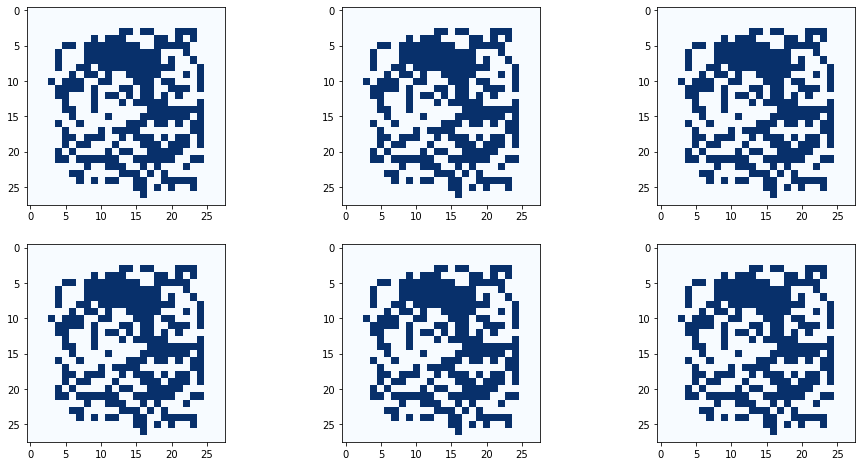

In [ ]:
# plot several outputs from the trained generator


# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

<br>

↪ 아직 모드붕괴는 여전하다

<br>

#### 💡💡 생성의 첫단계는 **시드**이므로, 입력 시드에 **충분히 많은 숫자**를 넣어서 테스트해보자!


```
self.model = nn.Sequential(
    nn.Linear(100,200),
    nn.LeakyReLU(0.02),

    nn.LayerNorm(200),
    
    nn.Linear(200,784),
    nn.Sigmoid()
)
```
↪ 위와 같이 생성자의 레이어 선언 부분에서, 임의의 값으로 입력노드를 **100**개 만들어보자! ⤵


In [ ]:
class Discriminator(nn.Module):
  
  # Constructor
  def __init__(self):

    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의 - 통과시킬 레이어를 순서대로 기술
    self.model = nn.Sequential(
        nn.Linear(784, 200),    # Linear : 완전연결 매핑을 의미 => 여기에서는 훈련 시 노드를 업데이트할 가중치에 대한 정보도 포함되어 있음
        # nn.Sigmoid(),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),      # Linear : ,,
        nn.Sigmoid()
    )

    # Loss Function 설정
    # self.loss_function = nn.MSELoss()
    self.loss_function = nn.BCELoss()

    # Optimizer 설정
    # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    # 훈련 시각화 (train 함수에서 사용될 변수 초기화)
    self.counter = 0
    self.progress = []


  # forward function : 네트워크에 정보 전달
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)


  # train
  def train(self, inputs, targets):
    # inputs  : 신경망에 전달할 입력  
    # targets : 원하는 목표 --> 이를 통해 손실을 계산

    ### 신경망 출력 계산
    outputs = self.forward(inputs)  # train 함수에서 가장 먼저 해야할 일! == forward()로 입력값을 신경망에 전달하여 결과를 얻어내는 것
    
    ### 손실 계산
    loss = self.loss_function(outputs, targets)
    #  계산 그래프의 마지막 노드는 손실함수!
    #   => 손실 계산을 위해 각 노드에서 기울기가 변하는 것은 각 학습 파라미터가 변할 때마다 손실이 변하는 것과 같음
    

    ### 훈련 시각화 (모니터링)
    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item()) # item() : 텐서에서 값을 꺼내오는 함수
    if (self.counter % 10000 == 0):
        print("counter = ", self.counter)


    ### 손실을 사용해 네트워크의 가중치를 업데이트
    # 기울기 초기화
    self.optimizer.zero_grad()  # 계산 그래프의 기울기가 모두 0으로 초기화
                                #   : 신경망을 훈련할 때마다 매번 기울기는 0으로 설정되어 있어야 함
                                #      => 그렇게 하지 않으면 loss.backward()를 따라 계산마다 쌓이게 됨
    # 역전파 실행
    loss.backward()
    # 가중치 갱신
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])

    # BCELoss()를 사용했기 때문에 값들이 0-1사이에 항상 머물러있진 않음. => 손실범위의 상한선을 없애고 수평격자선을 추가!
    # df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    

In [ ]:
class Generator(nn.Module):


  def __init__(self):
    
    # 파이토치 부모클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),
        
        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # 옵티마이저 설정
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

    # 진행측정을 위한 변수 초기화
    self.counter = 0
    self.progress = []



  def forward(self, inputs):
    
    # 모델 실행
    return self.model(inputs)


  def train(self, D, inputs, targets):

    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차계산
    loss = D.loss_function(d_output, targets)


    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter %10 == 0):
      self.progress.append(loss.item())
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    
    # BCELoss()를 사용했기 때문에 값들이 0-1사이에 항상 머물러있진 않음. => 손실범위의 상한선을 없애고 수평격자선을 추가!
    # df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


In [ ]:
%%time

# Create Discriminator and Generator

D = Discriminator()
G = Generator()


# Train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:
  
  # 01. train dicriminator on "real data"
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 02. train discriminator on "fake data"
  D.train(G.forward(generate_random(100)).detach(), torch.FloatTensor([0.0]))
          # use detach() so gradients in G are not calculated

  # 03. train generator
  G.train(D, generate_random(100), torch.FloatTensor([1.0]))
  

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 16min 45s, sys: 6.87 s, total: 16min 52s
Wall time: 16min 51s


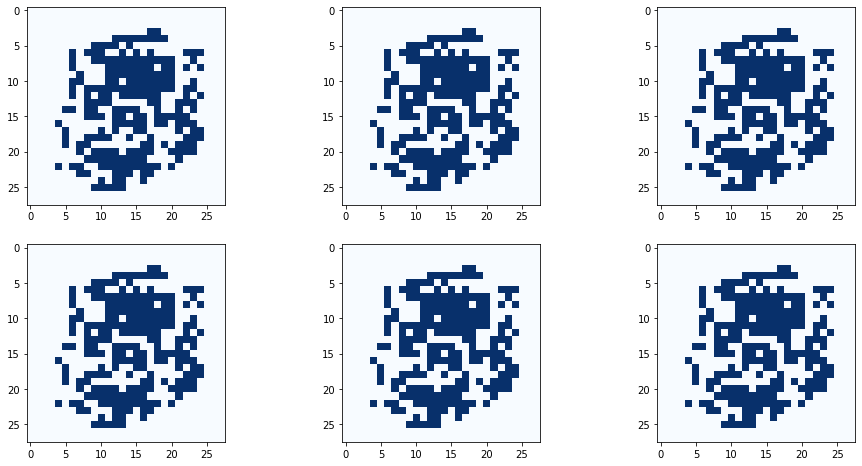

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(100))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

↪ 아직도 해결되지 않음...

<br>

#### 💡💡💡 판별기와 생성기에 시드를 주기 위한 임의의 값에 대해 계속 생각해보면, **이 둘에 입력되는 값이 달라야 할 것 같다**는 생각이 든다 



##### 🦋 **판별기**에 입력되는 "임의의 이미지 픽셀값"은 **0에서 1 사이에서 고르게 선택**해야 한다!!

> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ↪ 범위가 **0~1**인 이유는 이것이 **실제 데이터셋**에서 관찰되는 값이기 때문!<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ↪ 자연적으로 형성된 임의의 숫자에 대해 판별기의 성능을 테스트 할 것이기 때문에,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 값 또한 **고르게 선택되어야 하며** 정규분포처럼 어떠한 경향성을 지니면 안된다!  $^{*하단참고}$
<br>
```
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data
```


**cf) 정규분포, normal distribution** 🔥<br>
: 평균, 중앙값, 최빈값이 일치하며 좌우대칭이 되는 형태의 분포를 의미.
* 중심경향$^{central-tendency}$, 집중경향<br>
: 모집단 혹은 표본으로부터 얻어진 자료를 도표화하면 많은 자료가 어떤 특정한 값으로 몰리는 현상<br>
: 중심경향을 나타내는 특정한 값을 중심경향값 혹은 집중경향값이라고 함. 즉, 중심경향값이란 자료를 대표하는 값이라 할 수 있음.<br>
&nbsp;&nbsp;&nbsp;&nbsp; ↪ 종류 : **평균, 중앙값, 최빈값**<br>

##### 🦋 **생성기**에 투입되는 "임의의 값"은 **0부터 1 사이의 값이 아니어도** 된다!

> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ↪ 신경망에서 🔥**평균이 0이고 분산이 제한된 정규화된 값**들이 **학습에 유리**하다! 🔥 $^{*하단참고}$
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ↪ 다시말해, 생성기에서는 **표준정규분포**, 즉 **평균이 0이고 분산이 1인 분포**에서 값을 뽑는 것이 유리하다<br>
```
def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data
```


**cf) 가중치초기화** 🔥<br>
<밑바닥부터 시작하는 딥러닝> **ch06 학습관련기술들**에서 가중치를 초기화할 때 다뤄본 주제이기도 함

<br>

In [ ]:
def generate_random_image(size):
  random_data = torch.rand(size)  # 임의의 이미지 픽셀값이 0~1 사이에서 고르게 선택
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size) # 표준정규분포, 즉 평균이 0이고 분산이 1인 분포에서 값을 선택
  return random_data

↪ 이제, 시드를 각각 아래와 같이 사용<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;판별기 : <code>generate_random_image(784)</code><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;생성기 : <code>generate_random_seed(100)</code>

<br>

In [ ]:
%%time 

# Create Discriminator and Generator

D = Discriminator()
G = Generator()
# Train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

  # 01. train dicriminator on "real data"
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  
  # 02. train discriminator on "fake data"
  # use detach() so gradients in G are not calculated
  D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
  
  # 03. train generator
  G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 11min 31s, sys: 6.61 s, total: 11min 38s
Wall time: 12min 1s


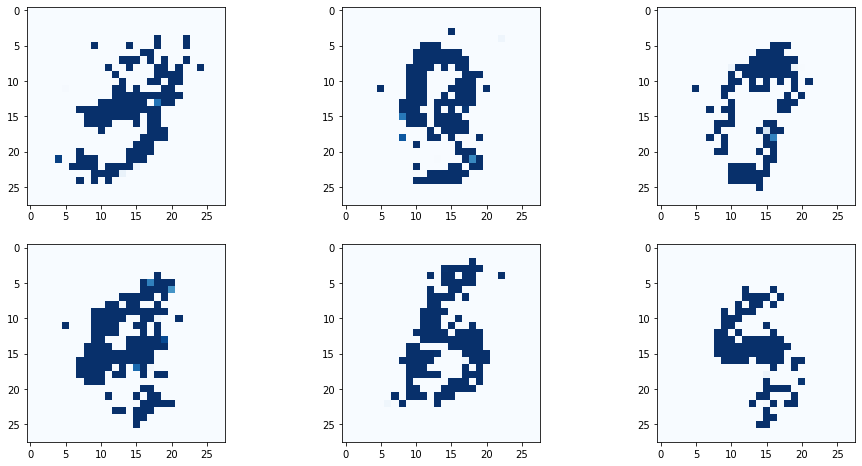

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

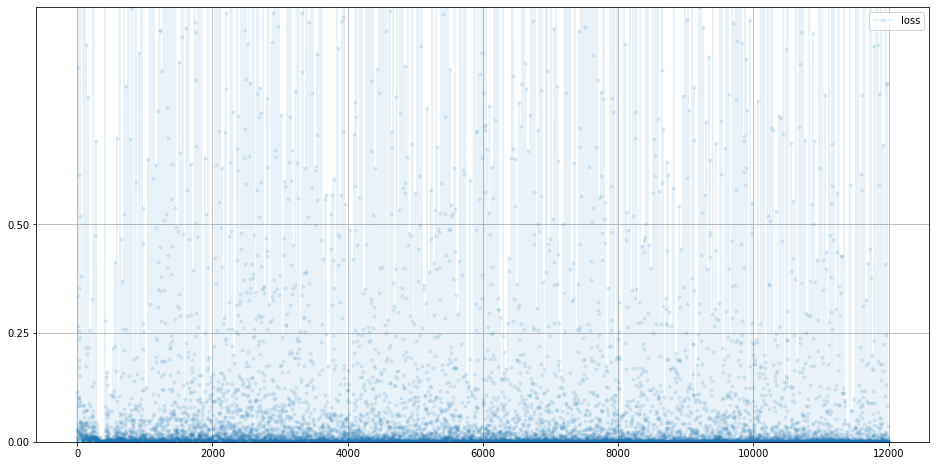

In [ ]:
# plot discriminator error

D.plot_progress()

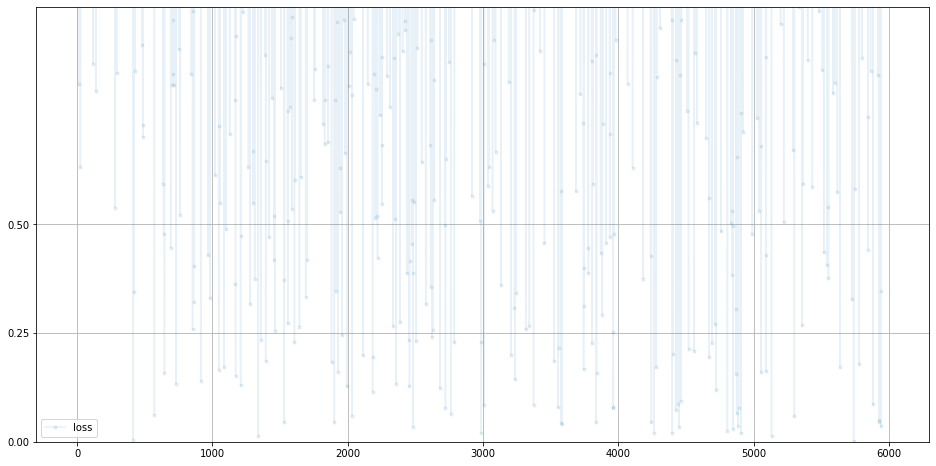

In [ ]:
# plot generator error

G.plot_progress()

#### 🦋 균형점에 도달했을 때, BCELoss()는 **어떤 값**을 가져야 하는가
{ 이진교차 엔트로피의 수학적인 정의에 따라, 아무 분류도 하지 못하는 분류기를 통과했을 때 예상되는 손실 } $ = {ln(2)} \approx 0.693$

> **부록 A**


<br>

#### 💡💡💡 **CUDA**를 적용한 후 높은 epoh 수로 GAN을 훈련시켜보자!



##### ✅ **에폭, epoh**
: 학습에서 훈련데이터를 모두 소진 했을 때의 횟수<br>
ex) 훈련데이터가 60,000개 있다면 미니배치로 100개씩 배치 하였을 때, SGD로 600회 반복하면 100 * 600 = 60,000개가 되어 1에폭이 된다.

<br>

In [7]:
# MNIST DATASET CLASS

class MnistDataset(Dataset):

  # Constructor
  def __init__(self, csv_file):
    # csv_file 읽어오기
    self.data_df = pandas.read_csv(csv_file, header=None)


  def __len__(self):
    # 데이터 프레임의 길이 반환
    return len(self.data_df)


  # 특정 아이템을 인덱스를 통해 접근가능한 함수
  def __getitem__(self,index):
    
    label = self.data_df.iloc[index,0]                                          # 01. index번째 행의 첫번째 인덱스, 즉 정답레이블을 읽어옴.(정답은 0~9까지 존재)
    target = torch.zeros((10))                                             # 02. target이란 변수명의 "정답" 종이 만들기
    target[label] = 1.0                                                         # 03. 정답 레이블의 위치에만 1로 지정. 나머지는 0 (원-핫 인코딩 방식)
    image_values = torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values)/255.0  # 04. 데이터를 tensor로 묶은 후 정규화 (0 - 255의 이미지를 0 - 1로 정규화)

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target



  # MNIST 데이터셋 내의 특정 이미지를 골라 차트를 그려보는 메서드
  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28) # 2D(28*28)로 변형
    plt.title("label = " + str(self.data_df.iloc[index,0])) # 정답레이블 제목으로 붙이기
    plt.imshow(img, interpolation='none', cmap = 'Blues')   # 나타내기

In [8]:
class Discriminator(nn.Module):
  
  # Constructor
  def __init__(self):

    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의 - 통과시킬 레이어를 순서대로 기술
    self.model = nn.Sequential(
        nn.Linear(784, 200),    # Linear : 완전연결 매핑을 의미 => 여기에서는 훈련 시 노드를 업데이트할 가중치에 대한 정보도 포함되어 있음
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),      # Linear : ,,
        nn.Sigmoid()
    )

    # Loss Function 설정
    self.loss_function = nn.BCELoss()

    # Optimizer 설정
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    # 훈련 시각화 (train 함수에서 사용될 변수 초기화)
    self.counter = 0
    self.progress = []


  # forward function : 네트워크에 정보 전달
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)


  # train
  def train(self, inputs, targets):
    # inputs  : 신경망에 전달할 입력  
    # targets : 원하는 목표 --> 이를 통해 손실을 계산

    ### 신경망 출력 계산
    outputs = self.forward(inputs)  # train 함수에서 가장 먼저 해야할 일! == forward()로 입력값을 신경망에 전달하여 결과를 얻어내는 것
    
    ### 손실 계산
    loss = self.loss_function(outputs, targets)
    #  계산 그래프의 마지막 노드는 손실함수!
    #   => 손실 계산을 위해 각 노드에서 기울기가 변하는 것은 각 학습 파라미터가 변할 때마다 손실이 변하는 것과 같음
    

    ### 훈련 시각화 (모니터링)
    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item()) # item() : 텐서에서 값을 꺼내오는 함수
    if (self.counter % 10000 == 0):
        print("counter = ", self.counter)


    ### 손실을 사용해 네트워크의 가중치를 업데이트
    # 기울기 초기화
    self.optimizer.zero_grad()  # 계산 그래프의 기울기가 모두 0으로 초기화
                                #   : 신경망을 훈련할 때마다 매번 기울기는 0으로 설정되어 있어야 함
                                #      => 그렇게 하지 않으면 loss.backward()를 따라 계산마다 쌓이게 됨
    # 역전파 실행
    loss.backward()
    # 가중치 갱신
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    

In [9]:
class Generator(nn.Module):


  def __init__(self):
    
    # 파이토치 부모클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),
        
        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # 옵티마이저 설정
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

    # 진행측정을 위한 변수 초기화
    self.counter = 0
    self.progress = []



  def forward(self, inputs):
    
    # 모델 실행
    return self.model(inputs)


  def train(self, D, inputs, targets):

    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차계산
    loss = D.loss_function(d_output, targets)


    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if (self.counter %10 == 0):
      self.progress.append(loss.item())
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()



  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    
    # BCELoss()를 사용했기 때문에 값들이 0-1사이에 항상 머물러있진 않음. => 손실범위의 상한선을 없애고 수평격자선을 추가!
    # df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


In [10]:
## Check if CUDA is available
## if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda : ", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [11]:
# Load MNIST Train Data

mnist_dataset = MnistDataset("mount/My Drive/Colab Notebooks/make-your-firstGAN-with-pytorch/mnist_data/mnist_train.csv")

In [ ]:
%%time 

# Create Discriminator and Generator

D = Discriminator()
G = Generator()

epochs = 16


# Train Discriminator and Generator

for epoch in range(epochs):

  print ("epoch = ", epoch + 1)

  for label, image_data_tensor, target_tensor in mnist_dataset:

    # 01. train dicriminator on "real data"
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # 02. train discriminator on "fake data"
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # 03. train generator
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))


epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
epoch =  5
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000


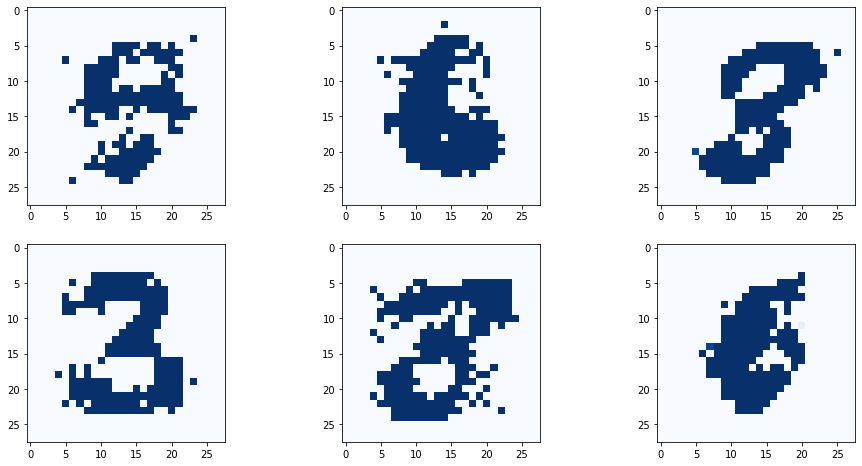

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.cpu().detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

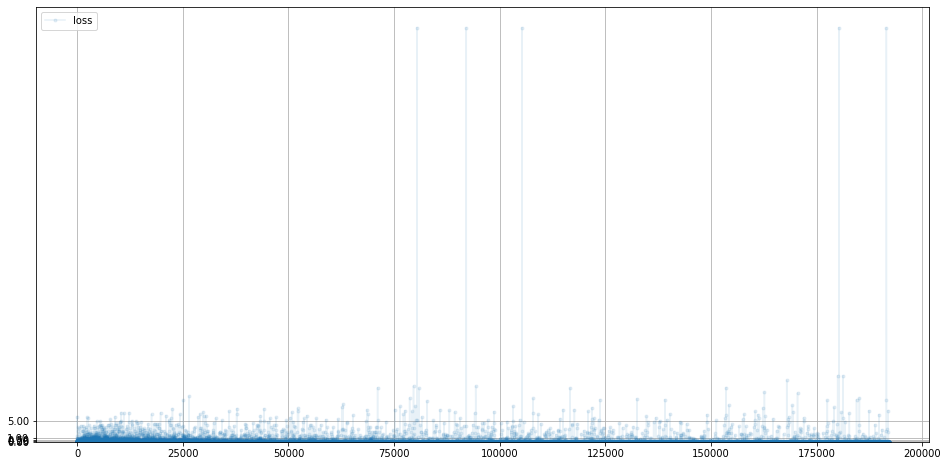

In [ ]:
# plot discriminator error

D.plot_progress()

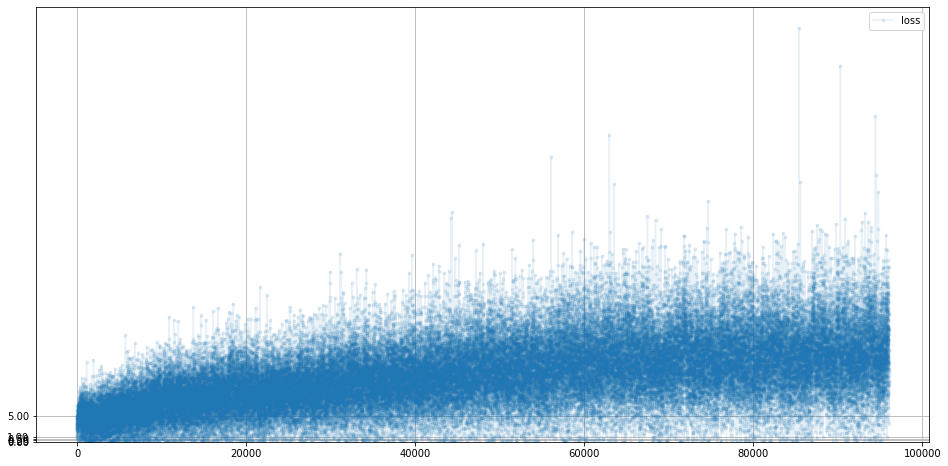

In [ ]:
# plot generator error

G.plot_progress()

16 에폭으로 돌렸더니 오버피팅이 된 것 같아서 4에폭으로 재도전!

In [ ]:
%%time 

# Create Discriminator and Generator

D = Discriminator()
G = Generator()

epochs = 4


# Train Discriminator and Generator

for epoch in range(epochs):

  print ("epoch = ", epoch + 1)

  for label, image_data_tensor, target_tensor in mnist_dataset:

    # 01. train dicriminator on "real data"
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # 02. train discriminator on "fake data"
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # 03. train generator
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))


In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.cpu().detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

In [ ]:
# plot discriminator error

D.plot_progress()

In [ ]:
# plot generator error

G.plot_progress()

## 시드로 실험하기

---

## **Summary**
> 🦋 GAN 훈련법<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp; (1) 실제 데이터셋 미리 살펴보기<br>
&nbsp;&nbsp;&nbsp;&nbsp; (2) 판별기가 적어도 임의의 노이즈와 실제 데이터를 구별하도록 학습할 수 있을 성능은 지니는 지 확인하기<br>
&nbsp;&nbsp;&nbsp;&nbsp; (3) 훈련되지 않은 생성기가 올바른 형태의 데이터를 만들어내는지 확인하기<br>
&nbsp;&nbsp;&nbsp;&nbsp; (4) 손실이 어떻게 변하는지 **시각화**하기
<br>
<br>

> * 잘 훈련된 GAN은 생성된 가짜 이미지와 실제 이미지를 잘 구별하지 못하는 상태<br>
즉, 출력은 0.5로서 0.0과 1.0의 중간에 해당하는 값.<br>
↪ 평균제곱오차의 이상적인 값은 0.25
* 생성기와 판별기를 각각 따로 시각화하는 것은 유용함.
* 생성기의 손실은 생성된 데이터로부터 발생한 판별기의 손실임.

---